# CS 109A/AC 209A/STAT 121A Data Science: Homework 4
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, October 5th, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW4.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [9]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from statsmodels.regression.linear_model import OLS
import sklearn.preprocessing as Preprocessing
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
from itertools import combinations
%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

[Tiwari, Sanjay]

### Part (b): Course Number

[CS 109a]

### Part (c): Who did you work with?

[No One]

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Variable selection and regularization

The data set for this problem is provided in ``dataset_1.txt`` and contains 10 predictors and a response variable.

### Part (a): Analyze correlation among predictors
- By visually inspecting the data set, do find that some of the predictors are correlated amongst themselves?


- Compute the cofficient of correlation between each pair of predictors, and visualize the matrix of correlation coefficients using a heat map. Do the predictors fall naturally into groups based on the correlation values?


- If you were asked to select a minimal subset of predictors based on the correlation information in order to build a good regression model, how many predictors will you pick, and which ones will you choose? 

In [15]:
# Load data
#data = np.loadtxt('communities-nohead.csv', delimiter=',')
data = np.loadtxt('communities-nonull.csv', delimiter=',', skiprows=1)

# Split predictors and response
x = data[:, :-1]
y = data[:, -1]

df = pd.DataFrame(data)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,126
0,8.0,0.0,0.0,1.0,0.19,0.33,0.02,0.90,0.12,0.17,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53.0,0.0,0.0,1.0,0.00,0.16,0.12,0.74,0.45,0.07,...,0.02,0.12,0.45,0.00,0.00,0.0,0.0,0.00,0.00,0.67
2,24.0,0.0,0.0,1.0,0.00,0.42,0.49,0.56,0.17,0.04,...,0.01,0.21,0.02,0.00,0.00,0.0,0.0,0.00,0.00,0.43
3,34.0,5.0,81440.0,1.0,0.04,0.77,1.00,0.08,0.12,0.10,...,0.02,0.39,0.28,0.00,0.00,0.0,0.0,0.00,0.00,0.12
4,42.0,95.0,6096.0,1.0,0.01,0.55,0.02,0.95,0.09,0.05,...,0.04,0.09,0.02,0.00,0.00,0.0,0.0,0.00,0.00,0.03


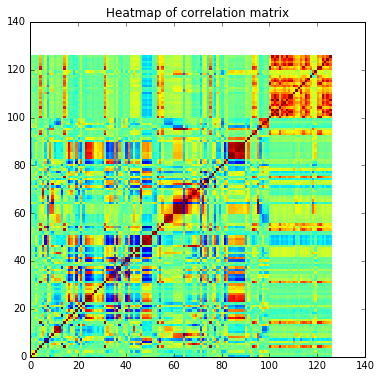

In [16]:
# Compute matrix of correlation coefficients

corr_matrix = np.corrcoef(x.T)

# Display heat map 
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.pcolormesh(corr_matrix)

ax.set_title('Heatmap of correlation matrix')

plt.show()

Variables in RGB colors show stronger corelation from +1 (Red) to 0 (GREEN) to -1 (Blue) on coefficient values. 

The following groups seems to show stronger relationships:  

Very Strong [0,1,2],[4,5,6] So only choose one from each group.

Weak[7,8,9]

A stronger relationship may help us to find which ones we can ignore and only evaluate one of the variables and not have to account all from the same relationship groups.

Q. How many predictors will you pick, and which ones will you choose? 

Based on the analysis done above I will choose 1+1+3 coefficients from each groups, and as following to avoid any colinearity:

[0],[4],[7,8,9]

### Part (b): Selecting minimal subset of predictors

- Apply the variable selection methods discussed in class to choose a minimal subset of predictors that yield high prediction accuracy:
    
    - Exhaustive search
    
    - Step-wise forward selection **or** Step-wise backward selection  

&emsp;&nbsp;&nbsp; In each method, use the Bayesian Information Criterion (BIC) to choose the subset size.

- Do the chosen subsets match the ones you picked using the correlation matrix you had visualized in Part (a)?

**Note**: You may use the `statsmodels`'s `OLS` module to fit a linear regression model and evaluate BIC. You may **not** use library functions that implement variable selection.

In [17]:
min_bic = 1e10 # set some initial large value for min BIC score
best_subset = [] # best subset of predictors

# Create all possible subsets of the set of 10 predictors
predictor_set = set(range(10)) # predictor set = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

# Repeat for every possible size of subset
for size_k in range(10): 
    # Create all possible subsets of size 'size', 
    # using the 'combination' function from the 'itertools' library
    subsets_of_size_k = it.combinations(predictor_set, size_k + 1) 
    
    max_r_squared = -1e10 # set some initial small value for max R^2 score
    best_k_subset = [] # best subset of predictors of size k
    
    # Iterate over all subsets of our predictor set
    for predictor_subset in subsets_of_size_k:    
        # Use only a subset of predictors in the training data
        x_subset = x[:, predictor_subset]

        # Fit and evaluate R^2
        model = OLS(y, x_subset)
        results = model.fit()
        r_squared = results.rsquared
        
        # Update max R^2 and best predictor subset of size k
        # If current predictor subset has a higher R^2 score than that of the best subset 
        # we've found so far, remember the current predictor subset as the best!
        if(r_squared > max_r_squared): 
            max_r_squared = r_squared
            best_k_subset = predictor_subset[:]
                

    # Use only the best subset of size k for the predictors
    x_subset = x[:, best_k_subset]
        
    # Fit and evaluate BIC of the best subset of size k
    model = OLS(y, x_subset)
    results = model.fit()
    bic = results.bic
    
    # Update minimum BIC and best predictor subset
    # If current predictor has a lower BIC score than that of the best subset 
    # we've found so far, remember the current predictor as the best!
    if(bic < min_bic): 
        min_bic = bic
        best_subset = best_k_subset[:]
    
print('Best subset by exhaustive search:')
print sorted(best_subset)

Best subset by exhaustive search:
[0, 2, 4, 5, 6, 7, 9]


In [5]:
###  Step-wise Backward Selection
d = x.shape[1] # total no. of predictors

# Keep track of current set of chosen predictors
current_predictors = range(d)

# First, fit and evaluate BIC using all 'd' number of predictors
model = OLS(y, x)
results = model.fit()
bic_all = results.bic

# Set the minimum BIC score, initially, to the BIC score using all 'd' predictors
global_min_bic = bic_all
# Keep track of the best subset of predictors
best_subset = [] 

# Iterate over all possible subset sizes, d predictors to 1 predictor
for size in range(d - 1, 1, -1): # stop before 0 to avoid choosing an empty set of predictors
    max_r_squared = -1e10 # set some initial small value for max R^2
    worst_predictor = -1 # set some throwaway initial number for the worst predictor to remove
    bic_without_worst_predictor = 1e10 # set some initial large value for min BIC score  
        
    # Iterate over current set of predictors (for potential elimination)
    for i in current_predictors:
        # Create copy of current predictors, and remove predictor 'i'
        temp = current_predictors[:]
        temp.remove(i)
                                    
        # Use only a subset of predictors in the training data
        x_subset = x[:, temp]
        
        # Fit and evaluate R^2
        model = OLS(y, x_subset)
        results = model.fit()
        r_squared = results.rsquared
        
        # Check if we get a higher R^2 value than than current max R^2, if so, update
        if(r_squared > max_r_squared):
            max_r_squared = r_squared
            worst_predictor = i
            bic_without_worst_predictor = results.bic
          
    # Remove worst predictor from current set of predictors
    current_predictors.remove(worst_predictor)
    
    # Check if BIC for the predictor we just removed is lower than 
    # the global minimum across all subset of predictors
    if(bic_without_worst_predictor < global_min_bic):
        best_subset = current_predictors[:]
        global_min_bic = bic_without_worst_predictor
    
print 'Step-wise backward subset selection:'
print sorted(best_subset)

Step-wise backward subset selection:
[0, 5, 7, 8, 9]


Q. Do the chosen subsets match the ones you picked using the correlation matrix you had visualized in Part (a)?

From Part 1 we found the following sets to be most useful : [0],[4 or 5],[7,8,9]

With both Backward and exhaustive search we see the results are very much in the lines and avoiding strong collinearity of predictors.

So yes answers and subsets mostly match from part a except the choise 4 or 5.

### Part (c): Apply Lasso and Ridge regression

- Apply Lasso regression with regularization parameter $\lambda = 0.01$ and fit a regression model.

    - Identify the predictors that are assigned non-zero coefficients. Do these correspond to  the correlation matrix in Part (a)?


- Apply Ridge regression with regularization parameter $\lambda = 0.01$ and fit a regression model.

    - Is there a difference between the model parameters you obtain different and those obtained from Lasso regression? If so, explain why.

    - Identify the predictors that are assigned non-zero coefficients. Do these correspond to  the correlation matrix in Part (a)?


- Is there anything peculiar that you observe about the coefficients Ridge regression assigns to the first three predictors? Do you observe the same with Lasso regression? Give an explanation for your observation.

**Note**: You may use the `statsmodels` or `sklearn` to perform Lasso and Ridge regression.

In [6]:
# Lasso regression
reg = Lasso_Reg(alpha = 0.01)
reg.fit(x, y)
coefficients = reg.coef_

print 'Lasso:'
print 'Coefficients:', coefficients
print  'Predictors with non-zero coefficients:', [i for i, item in enumerate(coefficients) if abs(item) > 0]

Lasso:
Coefficients: [ 0.          0.          0.04466466 -0.         -0.01760304 -0.         -0.
  0.04519336 -0.40460781 -0.22364868]
Predictors with non-zero coefficients: [2, 4, 7, 8, 9]


Q. Do these correspond to the correlation matrix in Part (a)?

A. From part a we can deduce [0 or 2],[4],[7,8,9] which lead to answers it gave us similar sets except choosing between 0 or 2.

In [7]:
# Ridge regression: Fit and evaluate 
reg = Ridge_Reg(alpha = 0.01)
reg.fit(x, y)
coefficients = reg.coef_

print 'Ridge:'
print 'Coefficients:', coefficients
print 'Predictors with non-zero coefficients:', [i for i, item in enumerate(coefficients) if abs(item) > 0]

Ridge:
Coefficients: [ 0.49399586 -0.88861864  0.12844832  0.55786427 -0.11836639 -0.59627951
  0.17221877  0.19104722 -0.51489429 -0.35759212]
Predictors with non-zero coefficients: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Q. Is there a difference between the model parameters you obtain different and those obtained from Lasso regression

Yes indeed we have all the predictors in Ridge regression with non-zero coefficients for such the lambda value. 
This make sense why Lasso was able to shrink coefficients for the given lambda value with Regularization with L1 approach of Lasso it is able to completely eliminate a coefficient as the RSS can reach minimization goal of Regularization and coefficient can be zero where RSS plot can touch the absolute value of (labmda.Sigma(ABS(Betas))) curve touching zero. 
Where as Ridge may have minimized (shrunk) values of coefficients but could not completetly eliminate in  L2 Regularization.

Q. Identify the predictors that are assigned non-zero coefficients. 

Since all them are chosen by Ridge these are listed above.
Do these correspond to the correlation matrix in Part (a)?
From part a we can deduce [0 or 2],[4],[7,8,9] this does not match with Ridge regression sets.

Q. Is there anything peculiar that you observe about the coefficients Ridge regression assigns to the first three predictors? 

First three coefficients in Ridge regression are 0.49399586, -0.88861864 and 0.12844832, two of them are positive and would give slightly weak slope but second one is above 0.8 and negative thus give reverse relation. Since these are highly correlated the net effect may not give us strong response out the fit.
Do you observe the same with Lasso regression? 
We observer first three coeefcients are 0, 0 and 0.04466466, this is different than that of the Ridge coefficients.
Give an explanation for your observation.
The net effect of both Regularization would have same effect, in case of Ridge it tends to produce a net weak response from the predictors. Whereas Lass will give us a weak response because the coefficient is rather very small only ~0.045. The results for both may be same.

## Problem 2: Cross-validation and Bootstrapping
In this problem, you will work with an expanded version of the automobile pricing data set you analyzed in Homework 3. The data set is contained ``dataset_2.txt``, with 26 attribues (i.e. predictors) for each automobile and corresponding prices. 

### Part(a): Encode categorical attributes and fill missing values
Identify the categorical attributes in the data. Replace their values with the one-hot binary encoding. You may do this using the `get_dummies()` function in `pandas`. If you do this task correctly, you should get a total of 69 predictors after the encoding.


In [23]:
pd_auto_data = pd.read_csv("datasets/dataset_2.txt")
pd_auto_data.fillna(0)
symboling = pd.Series(pd_auto_data['symboling'].round(), dtype="category")
pd_auto_data['symboling']= symboling


In [24]:
pd_auto_cate = pd.get_dummies(pd_auto_data) 
print pd_auto_cate.shape

(205, 69)


### Part (b): Apply regular linear regression
- Split the data set into train and test sets, with the first 25% of the data for training and the remaining for testing.  


- Use regular linear regression to fit a model to the training set and evaluate the R^2 score of the fitted model on both the training and test sets. What do you observe about these values?


- You had seen in class that the R^2 value of a least-squares fit to a data set would lie between 0 and 1. Is this true for the test R^2 values reported above? If not, give a reason for why this is the case.


- Is there a need for regularization while fitting a linear model to this data set?

**Note**: You may use the `statsmodels` or `sklearn` to fit a linear regression model and evaluate the fits.

In [202]:
from sklearn.cross_validation import train_test_split

X = pd_auto_cate.drop('price', axis=1) 
y = pd_auto_cate['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.25)    

model = OLS(y_train, X_train)
results = model.fit()
r_squared = results.rsquared
print "Train Data R^2:" , r_squared

#Lin_Reg
regression = Lin_Reg()

#Regression model X, y
regression.fit(X_train,y_train)

#predict y-values
#predicted_y = regression.predict(X_test)
test_score = regression.score(X_test, y_test)
print "Test Data R^2:" , test_score


Train Data R^2: 0.997289782343
Test Data R^2: -0.596757896426


Q. What do you observe about these values?

R^2 score of Train data is extremely high of 0.9973, indicating very good fit for the model.
R^2 values for test data is a negative value, that is quite in contract to train data.

Q. You had seen in class that the R^2 value of a least-squares fit to a data set would lie between 0 and 1. Is this true for the test R^2 values reported above? If not, give a reason for why this is the case.

Generally R^2 value should be between 0 and 1, however in this case of test data this a negative value.
A negative value of R^2 indicates model is arbitrarily worse. This can also indicate either very bad fit or unmatching test and train data or relying on a large feature set. In this case the R^2 score can be improved by inverting the train and test split to 75% vs 25% train for the whole set.


Q. Is there a need for regularization while fitting a linear model to this data set?

The train data score of 0.9975 indicates a very high degree of complexity resulting in over fitting of the predictors, 
thus improving a near perfect score of 1.0. 
We can use regularization to reduce the complexity and reduce the strong dependence on all the feature.

### Part (c): Apply Ridge regression

- Apply Ridge regression on the training set for different values of the regularization parameter $\lambda$ in the range $\{10^{-7}, 10^{-6}, \ldots, 10^7\}$. Evaluate the R^2 score for the models you obtain on both the train and test sets. Plot both values as a function of $\lambda$. 


- Explain the relationship between the regularization parameter and the training and test R^2 scores.


- How does the best test R^2 value obtained using Ridge regression compare with that of plain linear regression? Explain.

**Note**: You may use the `statsmodels` or `sklearn` to fit a ridge regression model and evaluate the fits.

In [22]:
#normalized Coefficients
from sklearn.cross_validation import train_test_split

X = pd_auto_cate.drop('price', axis=1) 
y = pd_auto_cate['price']

X = X / X.std()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.25)    

model = OLS(y_train, X_train)
results = model.fit()
r_squared = results.rsquared
print "Train Data R^2:" , r_squared

#Lin_Reg
regression = Lin_Reg()

#Regression model X, y
regression.fit(X_train,y_train)

#predict y-values
test_score = regression.score(X_test, y_test)
print "Test Data R^2:" , test_score


Train Data R^2: 1.0
Test Data R^2: 0.771586578732


In [23]:
# First, let's do plain OLS
#regression = Lin_Reg()
#regression.fit(X_train, y_train)

train_r_squared_plain = regression.score(X_train, y_train)
test_r_squared_plain = regression.score(X_test, y_test)

print 'Plain Regression: R^2 score on training set', train_r_squared_plain
print 'Plain Regression: R^2 score on test set', test_r_squared_plain

Plain Regression: R^2 score on training set 1.0
Plain Regression: R^2 score on test set 0.771586578732


In [24]:
# Ridge regression: Fit and evaluate 
reg = Ridge_Reg(alpha = 1.0)
reg.fit(X_train, y_train)
coefficients = reg.coef_

predictors = [i for i, item in enumerate(coefficients) if abs(item) > 0]

print 'Ridge Regression:'
print 'Normalized Coefficients:', coefficients.shape
print 'Selected predictors:',len(predictors)
print 'Ridge Regression: R^2 score on training set', reg.score(X_train,y_train)
print 'Ridge Regression: R^2 score on test set', reg.score(X_test,y_test)


Ridge Regression:
Normalized Coefficients: (68L,)
Selected predictors: 66
Ridge Regression: R^2 score on training set 0.997294130058
Ridge Regression: R^2 score on test set 0.916154165245


In [25]:
# Run for different values of lambda 
lambda_min = -7
lambda_max = 7

num_lambdas = 1000
num_predictors = X.shape[1]

lambdas= np.linspace(lambda_min,lambda_max, num_lambdas)

train_r_squared = np.zeros(num_lambdas)
test_r_squared = np.zeros(num_lambdas)

coeff_a =np.zeros((num_lambdas, num_predictors))

In [26]:
for ind, i in enumerate(lambdas):    
    # Fit ridge regression on train set
    reg = Ridge_Reg(alpha = 10**i)
    reg.fit(X_train, y_train)
       
    coeff_a[ind,:] = reg.coef_
    # Evaluate train & test performance
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)   

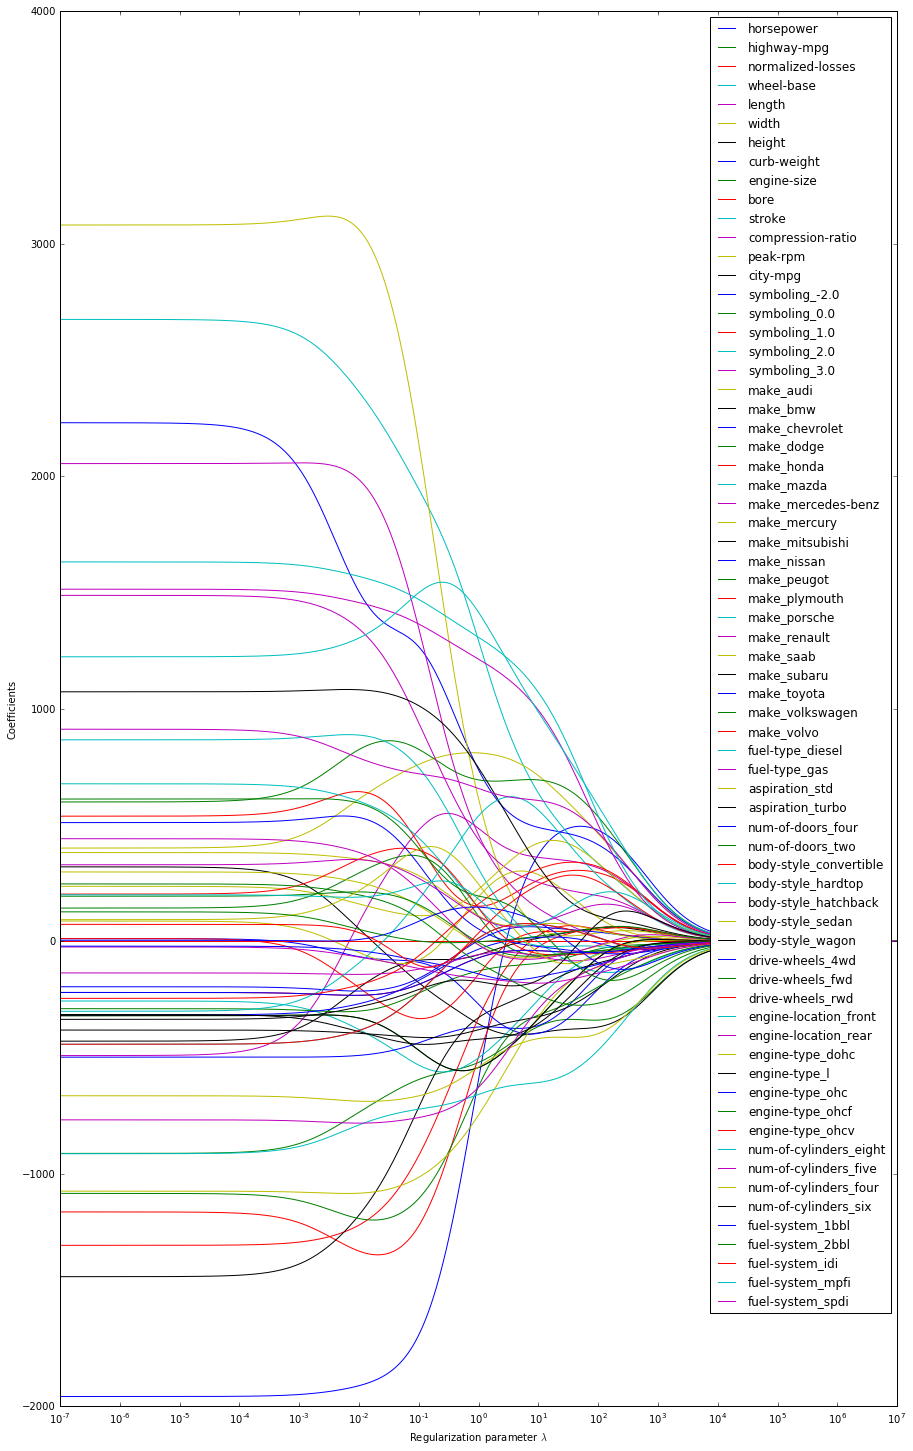

In [27]:
plt.figure(figsize=(15,25))
h=plt.semilogx(10**lambdas, coeff_a);
plt.ylabel("Coefficients")
plt.xlabel(r'Regularization parameter $\lambda$')
plt.legend(h, X.columns.values)
plt.show()

Q. Explain the relationship between the regularization parameter and the training and test R^2 scores.

From the figure above it is evident that as lambda value goes up all the coefficients are shrunk to a much smaller values, the drop in coefficient value is quite steep after lambda > 10^-5. Before the value of lambda was insignificant high coefficients values dominated regression model but as the lambda value increases beyond 10^3 some of coefficient values got a significantly drop close to zero and as the lambda approaches 1 some of the coefficients values are reduced to insignificant value.

Ridge Regression: max R^2 score on training set 1.0
Ridge Regression: max R^2 score on test set 0.936426163714


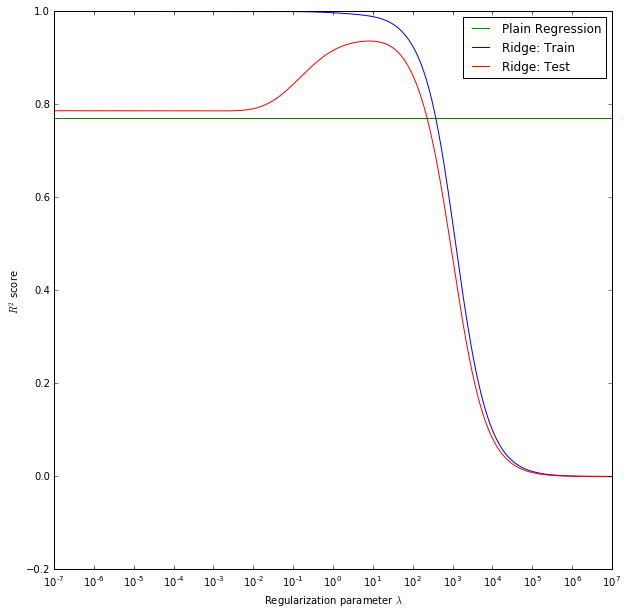

In [28]:
# Plot train an test R-squared as a function parameter value
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.semilogx(y = test_r_squared_plain, c='g', label = 'Plain Regression')
ax.semilogx(10.0**lambdas, (train_r_squared), c='b', label='Ridge: Train')
ax.semilogx(10.0**lambdas, (test_r_squared), c='r', label='Ridge: Test')


ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'$R^2$ score')

#ax.set_ylim((test_r_squared_plain-0.2, 1.2))
ax.legend(loc = 'best')

print 'Ridge Regression: max R^2 score on training set', max(train_r_squared)
print 'Ridge Regression: max R^2 score on test set', max(test_r_squared)

reg = Lasso_Reg(alpha =lambdas[np.argmax(test_r_squared)])
reg.fit(X_train, y_train)
coefficients = reg.coef_
plt.show()


Q. How does the best test R^2 value obtained using Ridge regression compare with that of plain linear regression? Explain.

As we have substantially large (69) predictors in this problem the normal multivariate regression end up having a significant increase in variance even though the bias has decreased due to better model fit with the train data, where we noticed that the R^2 score is close to 1.0. However at the same time the test R^2 score plummeted to deplorable value and some times it became negative indicating plain regression on test data has become arbitrarily worse.

In contrast the test R^2 scores for test data improved using ridge regression. This has been plotted in the figure above showing as the value of lambda is increased from 10^-3 to 0.1, where max R^2 score of 0.94 for test data became as good as that of R^2 score of 0.9997 on train data. This is direct result of reducing some coefficients to near zero as lambda increases thus reducing the overfitting (getting optimal bias and variance) of the model and optimizes the model for better fit. 

### Part (d): Tune regularization parameter using cross-validation and bootstrapping
-  Evaluate the performance of the Ridge regression for different regularization parameters $\lambda$ using 5-fold cross validation **or** bootstrapping on the training set. 

    - Plot the cross-validation (CV) or bootstrapping R^2 score as a function of $\lambda$. 
    
    - How closely does the CV score or bootstrapping score match the R^2 score on the test set? Does the model with lowest CV score or bootstrapping score correspond to the one with maximum R^2 on the test set?
    
    - Does the model chosen by CV or bootstrapping perform better than plain linear regression?

**Note**: You may use the `statsmodels` or `sklearn` to fit a linear regression model and evaluate the fits. You may also use `kFold` from `sklearn.cross_validation`. 

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


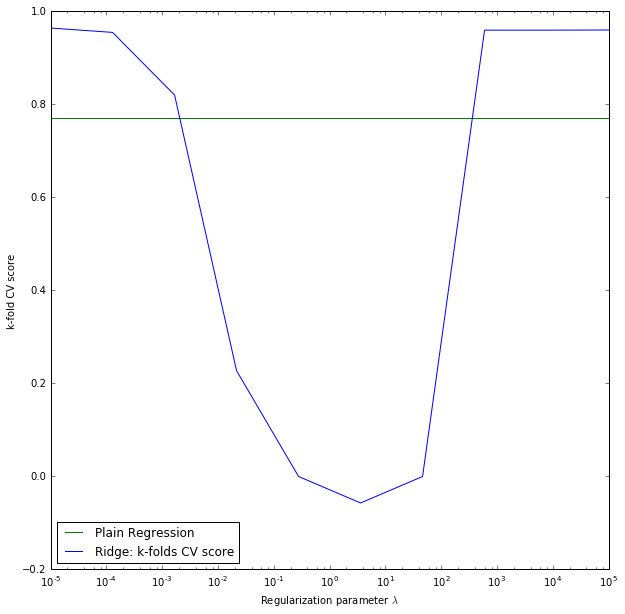

In [29]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn import svm

n_folds=5

lambda_min = -5
lambda_max = 5

num_lambdas = 10

lambdas= np.linspace(lambda_min,lambda_max, num_lambdas)

k_fol_scores = np.zeros(num_lambdas)
test_r_squared_c = np.zeros(num_lambdas)

#for i in range(n_folds):    
#    k_fol_scores[i] = np.zeros(num_lambdas)

for ind, i in enumerate(lambdas):    
    # Fit ridge regression on train set
    reg = Ridge_Reg(alpha = 10**i)
    reg.fit(X_train, y_train)
    
    test_r_squared_c[ind] = reg.score(X_test, y_test)       
    
    k_fold = KFold(y.shape[0], n_folds, shuffle=True, random_state=0)
    some_value =  cross_val_score(reg, X, y, cv=k_fold, n_jobs=1)
    k_fol_scores[i] =  some_value.mean()
       
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.semilogx(y = test_r_squared_plain, c='g', label = 'Plain Regression')
ax.semilogx(10.0**lambdas, (k_fol_scores), c='b', label='Ridge: k-folds CV score')
#ax.semilogx(10.0**lambdas, (test_r_squared_c), c='r', label='Ridge: test score')


ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'k-fold CV score')

ax.legend(loc = 'best')

plt.show()


In [30]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

reg = Ridge_Reg(alpha = 0.000000001)
reg.fit(X_train, y_train)

k_fold = KFold(y.shape[0], n_folds=4, shuffle=True, random_state=0)
#clf = <any classifier>

print cross_val_score(reg, X, y, cv=k_fold, n_jobs=1)

[ 0.92306668  0.92735058  0.9674258   0.949978  ]


In [31]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn import svm

k_fold = KFold(y.shape[0], n_folds=2, shuffle=True, random_state=0)
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)

print cross_val_score(clf, X, y, cv=k_fold, n_jobs=1)

[ 0.54368932  0.56862745]


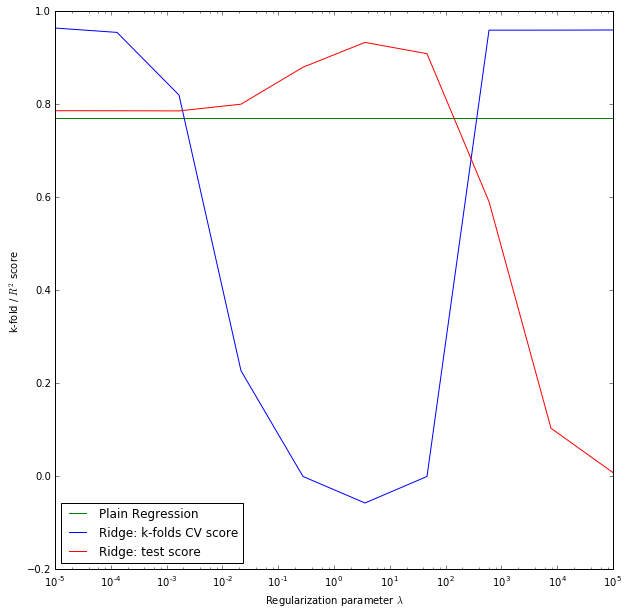

In [32]:
      
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.semilogx(y = test_r_squared_plain, c='g', label = 'Plain Regression')
ax.semilogx(10.0**lambdas, (k_fol_scores), c='b', label='Ridge: k-folds CV score')
ax.semilogx(10.0**lambdas, (test_r_squared_c), c='r', label='Ridge: test score')


ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'k-fold / $R^2$ score')

ax.legend(loc = 'best')

plt.show()


Q. How closely does the CV score or bootstrapping score match the R^2 score on the test set?

The k-fold score is shown as Blue line in chart above and R^2 score of test data using the test set is shown in red. The k-fold score is very high for certan type of lambda values.

Q. Does the model with lowest CV score or bootstrapping score correspond to the one with maximum R^2 on the test set?

No. Looking at the chart the test score and k-fold optimze on certain range of values of lambda only.

Q. Does the model chosen by CV or bootstrapping perform better than plain linear regression?

CV model performed very well for optimized choices of lambda and it seems to result very consistent behavior.

## Problem 3: Ridge regression *via* ordinary least-squares regression

We present an approach to implement Ridge regression using oridinary least-squares regression. Given a matrix of responses $\mathbf{X} \in \mathbb{R}^{n\times p}$ and response vector $\mathbf{y} \in \mathbb{R}^{n}$, one can implement Ridge regression with regularization parameter $\lambda$ as follows:

- Augment the matrix of predictors $\mathbf{X}$ with $p$ new rows containing the scaled identity matrix $\sqrt{\lambda}\mathbf{I} \in \mathbb{R}^{p \times p}$, i.e.
$$\overline{\mathbf{X}} \,=\, 
\begin{bmatrix}
X_{11} & \ldots & X_{1p}\\
\vdots & \ddots & \vdots\\
X_{n1} & \ldots & X_{np}\\
\sqrt{\lambda} & \ldots & 0\\
\vdots & \ddots & \vdots\\
0 & \ldots & \sqrt{\lambda}
\end{bmatrix}
\,\in\,
\mathbb{R}^{(n+p)\times p}
.
$$


- Augment the response vector $\mathbf{y}$ with a column of $p$ zeros, i.e.
$$
\overline{\mathbf{y}} \,=\, 
\begin{bmatrix}
y_{1}\\
\vdots\\
y_{n}\\
0\\
\vdots\\
0
\end{bmatrix}
\,\in\,
\mathbb{R}^{n+p}.
$$


- Apply ordinary least-squares regression on the augmented data set $(\overline{\mathbf{X}}, \overline{\mathbf{y}})$.

### Part (a): Show the proposed approach implements Ridge regression
Show that the approach proposed above implements Ridge regression with parameter $\lambda$.

A. We know given a data set we minimize the following for Ridge regression:
    $$ \sum_{i=1}^{n}\left(y_i  - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2  + \lambda \sum_{j=1}^{p} \beta_k^2 = RSS + \lambda \sum_{j=1}^{p} \beta_k^2 $$


The given matrix minimization is indeed the same problem as shown in the equation above. 
We know that $y_{i}$ would be calculated as a function of ($x_i, ..., x_{ip}$),
so for e.g. $y_{1}$ will be calculated ($x_1, ..., x_{1p}$), 
applying  regression we will get the all ys up to n size as ($y_1, ..., y_{n}$). 

Using test-squares regression this will give us RSS from the equation above. 
This is same as we saw in multivariate  Y =  $\beta$X when accounted for X matrix size p x n.

In the above problem we see beyond $y_{n}$, i.e. $y_{n+1}$, 
there is an extra term willl 0 repeated for p responses consisting of p x p matrix predictors, 
yet we have to still compute all the $\sqrt{\lambda}\mathbf{I}$. 
Continue using test-squares regression the remaining matrix we have to get difference of all the zeros coming 
from ($y_{n+1}, ..., y_{n+p}$) with squared terms of
$\sqrt{\lambda}$ will give us $\lambda$ and an extra squared unknown multiple (coefficient), 
calculated as ($\sqrt{\lambda}.\beta_k - 0)^2$, 
which is indeed $\beta_k^2$ as represented in the equation above.


### Part (b): Debug our implementation of ridge regression
You're a grader for CS109A, the following is an implemention of Ridge regression (via the above approach) submitted by a student. The dataset is ``dataset_3.txt``. The regression model is fitted to a training set, and the R^2 scores of the fitted model on the training and test sets are plotted as a function of the regularization parameter. Grade this solution according to the following rubric (each category is equally weighted): 

- correctness

- interpretation (if applicable)

- code/algorithm design

- presentation

In addition to providing an holistic grade (between 0 to 5), provide a corrected version of this code that is submission quality.

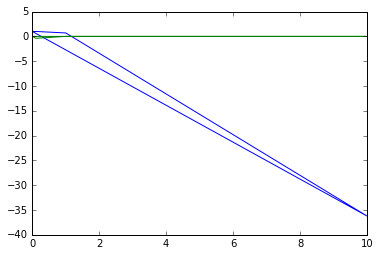

In [90]:
# Fit
def ridge(x_train, y_train, reg_param):
    n=np.shape(x_train)[0]
    x_train=np.concatenate((x_train,reg_param*np.identity(n)),axis=1)
    y_train_=np.zeros((n+np.shape(x_train)[1],1))
    for c in range(n):
        y_train_[c]= y_train[c]
    import sklearn
    model = sklearn.linear_model.LinearRegression()
    model.fit(x_train,y_train.reshape(-1,1))
    return model

# Score
def score(m,x_test,y_test, reg_param):
    n=np.shape(x_train)[0]
    x_test=np.concatenate((x_test,reg_param*np.identity(n)),axis=1)
    y_test_=np.zeros((n+np.shape(x_test)[1],1))
    for c in range(n):
        y_test_[c]= y_test[c]
    return m.score(x_test,y_test.reshape(-1,1))

# Load
data = np.loadtxt('datasets/dataset_3.txt', delimiter=',')

n = data.shape[0]
n = int(np.round(n*0.5))
x_train = data[0:n,0:100]
y_train = data[0:n,100]
x_test = data[n:2*n,0:100]
y_test = data[n:2*n,100]

# Params
a=np.zeros(5)
for i in range(-2,2):
    a[i+2]=10**i

# Iterate
rstr =np.zeros(5)
rsts =np.zeros(5)
for j in range(0,5):    
    m =ridge(x_train,y_train,a[i])
    rstr[j]=score(m,x_train,y_train,a[j])
    rsts[i]=score(m,x_test,y_test,a[i])

# Plot
plt.plot(a,rstr)
plt.plot(a,rsts)

Grade:
correctness            1.25 : +0.25 Because the answer is wrong.
interpretation         1.25 : +1.25 understood the problem and had the correct approach.
code/algorithm design  1.25 : +1.00 code did work but with several mistakes and inefficiencies.
presentation           1.25 : +0.75 Chart did not have titles or labels or convayed information
Total Grade  out of    5.00 :  3.25        

Correct solution with a few modifications:

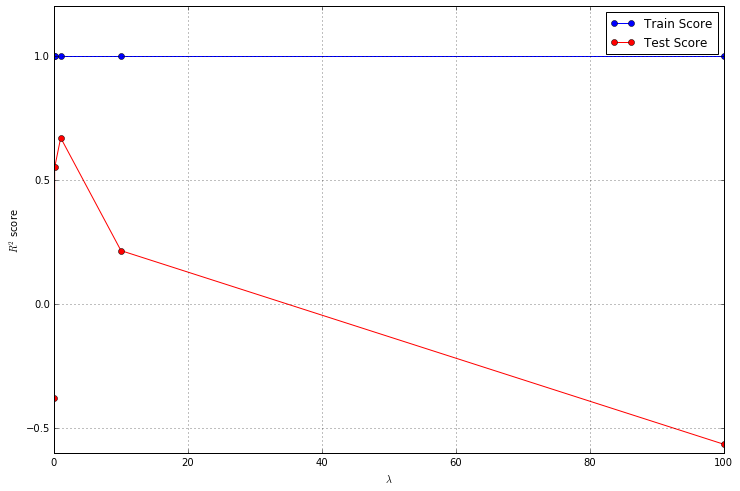

In [91]:
import sklearn

# Fit
def ridge(x_train, y_train, reg_param):
    n=np.shape(x_train)[0]
    augmented_lambda = (reg_param*np.identity(n))**0.5
    x_train=np.concatenate((x_train, augmented_lambda),axis=1)
    model = sklearn.linear_model.LinearRegression()
    model.fit(x_train,y_train)

    return model

# Score
def score(model,x_test,y_test, reg_param):
    n=np.shape(x_train)[0]
    augmented_lambda = (reg_param*np.identity(n))**0.5
    x_test=np.concatenate((x_test,augmented_lambda),axis=1)
    return model.score(x_test,y_test)

# Load
data = np.loadtxt('datasets/dataset_3.txt', delimiter=',')

m = data.shape[1] -1 

n = data.shape[0]
n = int(np.round(n*0.5))
x_train = data[0:n,0:m]
y_train = data[0:n,m]
x_test = data[n:2*n,0:m]
y_test = data[n:2*n,m]

# Params  
distn = 5
l_values=np.zeros(distn)
for i in range(0,distn):
    l_values[i]=10**(i-(distn/2))

# Iterate
rstr =np.zeros(distn)
rsts =np.zeros(distn)

for j in range(0,distn):    
    model  =ridge(x_train,y_train,l_values[j])
    rstr[j]=score(model,x_train,y_train,l_values[j])
    rsts[j]=score(model,x_test,y_test,l_values[j])

# Plot
plt.figure(figsize=(12,8))
plt.plot(l_values,rstr, 'bo-', label=r'Train Score')
plt.plot(l_values,rsts, 'ro-', label=r'Test Score')

plt.xlabel(r'$\lambda$'); plt.ylabel(r'$R^2$ score')
plt.legend(loc='best')
plt.grid()
plt.show()

## Challenge Problem: Predicting Outcome of a Fund-raising Campaign
You are provided a data set containing details of mail sent to 95,412 potential donors for a fund-raising campaign of a not-for-profit organization. This data set also contains the amount donated by each donor. The task is to build a model that can estimate the amount that a donor would donate using his/her attributes. The data is contained in the file `dataset_4.txt`. Each row contains 376 attributes for a donor, followed by the donation amount.

**Note**: For additional information about the attributes used, please look up the file `dataset_4_description.txt`. This files also contains details of attributes that have been omitted from the data set.

### Part (a): Fit regression model
Build a suitable model to predict the donation amount. How good is your model? 


### Part (b): Evaluate the total profit of the fitted model
Suppose you are told that the cost of mailing the donor is \$7. Use your model to maximize profit. Implement, explain and rigorously justify your strategy. How does your strategry compare with blanket mailing everyone.

### Part (c): Further Discussion
In hindsight, thoroughly discuss the appropriatenes of using a regression model for this dataset (you must at least address the suitability with respect to profit maximization and model assumptions). Rigorously justify your reasoning. 

In [2]:
pd_fund_data = pd.read_csv("datasets/dataset_4.txt", low_memory=False)

def cleanup_data(pd_data):
    pd_data['RFA_DONOR'] = pd_data['MDMAUD'].str.contains('^[clidCLID]')
    pd_data['RFA_FREQ'] = pd_data['MDMAUD'].str.contains('^.[12345]')
    pd_data['RFA_AMT'] = pd_data['MDMAUD'].str.contains('^..[lcmtLCMT]')
    pd_data['RFA_DONOR'] = 0.0
    pd_data['RFA_FREQ'] = 0.0
    pd_data['RFA_AMT'] = 0.0
    
    p1_D1_idx = pd_data[pd_data['MDMAUD'].str.contains('^[cC]') == True].index.tolist()
    p1_D2_idx = pd_data[pd_data['MDMAUD'].str.contains('^[iI]') == True].index.tolist()
    p1_D3_idx = pd_data[pd_data['MDMAUD'].str.contains('^[lL]') == True].index.tolist()
    p1_D4_idx = pd_data[pd_data['MDMAUD'].str.contains('^[dD]') == True].index.tolist()
    p1_D_idx = p1_D1_idx + p1_D2_idx + p1_D3_idx + p1_D4_idx

    p2_F1_idx = pd_data[pd_data['MDMAUD'].str.contains('^.[1]') == True].index.tolist()
    p2_F2_idx = pd_data[pd_data['MDMAUD'].str.contains('^.[23456]') == True].index.tolist()
    
    p3_A1_idx = pd_data[pd_data['MDMAUD'].str.contains('^..[L]') == True].index.tolist()
    p3_A2_idx = pd_data[pd_data['MDMAUD'].str.contains('^..[C]') == True].index.tolist()
    p3_A3_idx = pd_data[pd_data['MDMAUD'].str.contains('^..[M]') == True].index.tolist()
    p3_A4_idx = pd_data[pd_data['MDMAUD'].str.contains('^..[T]') == True].index.tolist()
    p3_A_idx = p3_A1_idx + p3_A2_idx + p3_A3_idx + p3_A4_idx
    
    for a in (p1_D_idx):
        if a in p1_D1_idx:
            pd_data.loc[a, 'RFA_DONOR'] = 100.0
        elif a in p1_D2_idx:
            pd_data.loc[a, 'RFA_DONOR'] = 50.0
        elif a in p1_D3_idx:
            pd_data.loc[a, 'RFA_DONOR'] = 25.0
        elif a in p1_D4_idx:
            pd_data.loc[a, 'RFA_DONOR'] = 1.0
    
    for a in (p2_F1_idx + p2_F2_idx):
        if a in p2_F1_idx:
            pd_data.loc[a, 'RFA_FREQ'] = 100.00
        elif a in p2_F2_idx:
            pd_data.loc[a, 'RFA_FREQ'] = 200.00
    
    for a in (p3_A_idx):
        if a in p3_A1_idx:
            pd_data.loc[a, 'RFA_AMT'] = 99.0
        elif a in p3_A2_idx:
            pd_data.loc[a, 'RFA_AMT'] = 499.0
        elif a in p3_A3_idx:
            pd_data.loc[a, 'RFA_AMT'] = 999.0
        elif a in p3_A4_idx:
            pd_data.loc[a, 'RFA_AMT'] = 1000.0
            
    pd_data.drop('MDMAUD',1)
    
    
    pd_data['DOMAIN_SES'] = pd_data['DOMAIN'].str.contains('^[uU]')
    
    p1_U_15_idx = pd_data[pd_data['DOMAIN'].str.contains('^[uU]') == True].index.tolist()
    p1_NU_12_idx = pd_data[pd_data['DOMAIN'].str.contains('^[cstrCSTR]') == True].index.tolist()
    p2_1_idx = pd_data[pd_data['DOMAIN'].str.contains('^.[1]') == True].index.tolist()
    p2_2_idx = pd_data[pd_data['DOMAIN'].str.contains('^.[2]') == True].index.tolist()
    p2_3_idx = pd_data[pd_data['DOMAIN'].str.contains('^.[3]') == True].index.tolist()
    p2_4_idx = pd_data[pd_data['DOMAIN'].str.contains('^.[4]') == True].index.tolist()
    
    pd_data['DOMAIN_SES'] = 0.0
    
    for a in (p1_U_15_idx + p1_NU_12_idx):
        if a in p1_U_15_idx:
            if a in p2_1_idx:
                pd_data.loc[a, 'DOMAIN_SES'] = 100.0
            elif a in p2_2_idx:
                pd_data.loc[a, 'DOMAIN_SES'] = 200.0
            elif a in p2_3_idx:
                pd_data.loc[a, 'DOMAIN_SES'] = 400.0
            elif a in p2_4_idx:
                pd_data.loc[a, 'DOMAIN_SES'] = 500.0
        elif a in p1_NU_12_idx:
            if a in p2_1_idx:
                pd_data.loc[a, 'DOMAIN_SES'] = 100.0
            elif a in p2_2_idx:
                pd_data.loc[a, 'DOMAIN_SES'] = 300.0
    
    pd_data.drop('DOMAIN',1)
    new_pd = pd_data

    return new_pd;


print pd_fund_data.shape

pd_fund_cate = cleanup_data(pd_fund_data)

all_cols = pd_fund_cate.columns

pd_fund_cate = pd.get_dummies(pd_fund_data) 
pd_fund_cate.fillna(0)
print pd_fund_cate.shape


(8928, 377)
(8928, 2894)


Ridge Regression: max R^2 score on training set 0.692018159989
Ridge Regression: max R^2 score on test set 0.0942349662601


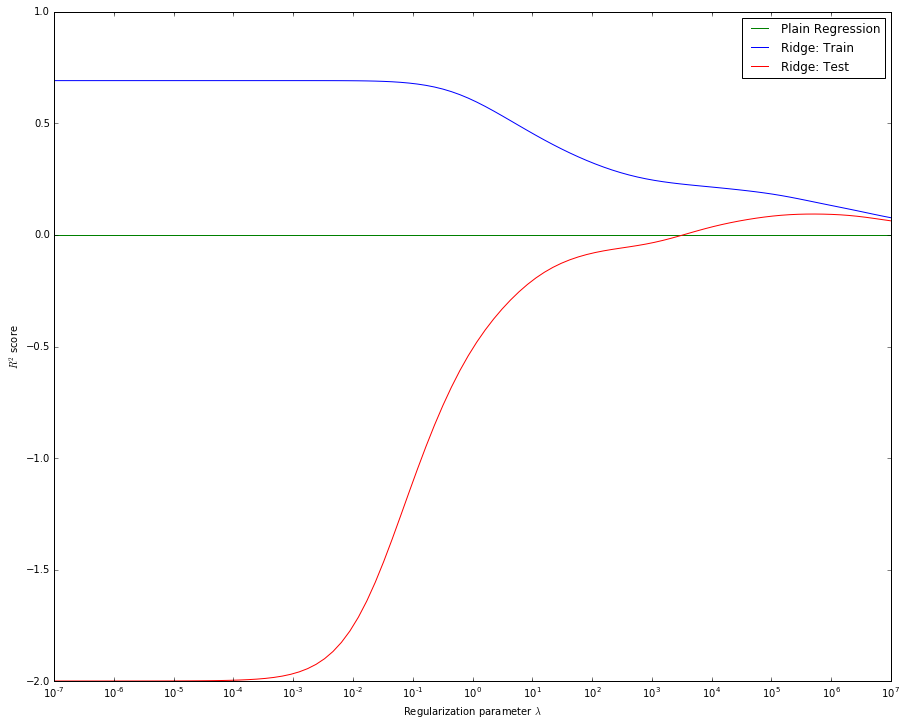

In [30]:
# Run for different values of lambda for Ridge regression
from sklearn.cross_validation import train_test_split

X = pd_fund_cate.drop('TARGET_D', axis=1) 
y = pd_fund_cate['TARGET_D']

#this leads to some problem so ignoring it for now
#X = X / X.std()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.50)    

#this does not fit to excluding this from our implementation
#model = OLS(y_train, X_train)
#results = model.fit()

lambda_min = -7
lambda_max = 7

num_lambdas = 100
num_predictors = X.shape[1]

lambdas= np.linspace(lambda_min,lambda_max, num_lambdas)

train_r_squared = np.zeros(num_lambdas)
test_r_squared = np.zeros(num_lambdas)
test_r_squared_plain =0.0

for ind, i in enumerate(lambdas):    
    # Fit ridge regression on train set
    reg = Ridge_Reg(alpha = 10**i)
    reg.fit(X_train, y_train)
       
    # Evaluate train & test performance
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)

# Plot train an test R-squared as a function parameter value
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

ax.axhline(y = test_r_squared_plain, c='g', label = 'Zero Line')
ax.semilogx(10.0**lambdas, (train_r_squared), c='b', label='Ridge: Train')
ax.semilogx(10.0**lambdas, (test_r_squared), c='r', label='Ridge: Test')


ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'$R^2$ score')

ax.legend(loc = 'best')

print 'Ridge Regression: max R^2 score on training set', max(train_r_squared)
print 'Ridge Regression: max R^2 score on test set', max(test_r_squared)

Lasso Regression: max R^2 score on training set 0.64221684243
Lasso Regression: max R^2 score on test set 0.118079309166


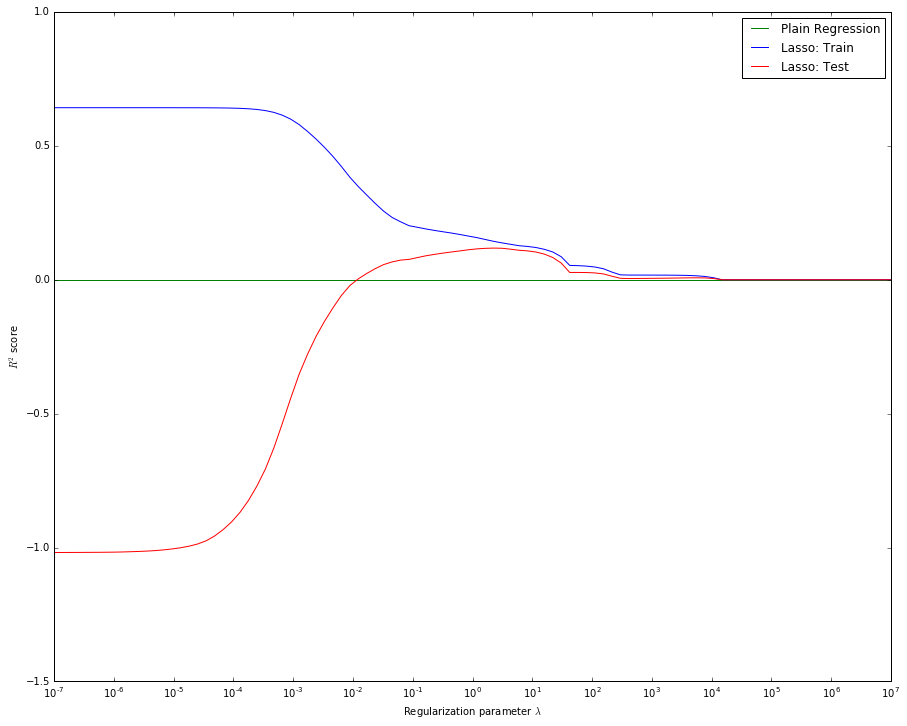

In [10]:
# Run for different values of lambda for Lasso 
from sklearn.cross_validation import train_test_split

X = pd_fund_cate.drop('TARGET_D', axis=1) 
y = pd_fund_cate['TARGET_D']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.50)    


lambda_min = -7
lambda_max = 7

num_lambdas = 100
num_predictors = X.shape[1]

lambdas= np.linspace(lambda_min,lambda_max, num_lambdas)

train_r_squared = np.zeros(num_lambdas)
test_r_squared = np.zeros(num_lambdas)
test_r_squared_plain =0.0

for ind, i in enumerate(lambdas):    
    # Fit ridge regression on train set
    reg = Lasso_Reg(alpha =10**i, max_iter=100)
    reg.fit(X_train, y_train)
       
    # Evaluate train & test performance
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)

# Plot train an test R-squared as a function parameter value
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

ax.axhline(y = test_r_squared_plain, c='g', label = 'Zero Line')
ax.semilogx(10.0**lambdas, (train_r_squared), c='b', label='Lasso: Train')
ax.semilogx(10.0**lambdas, (test_r_squared), c='r', label='Lasso: Test')


ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'$R^2$ score')

ax.legend(loc = 'best')

print 'Lasso Regression: max R^2 score on training set', max(train_r_squared)
print 'Lasso Regression: max R^2 score on test set', max(test_r_squared)

plt.show()


Lasso Regression: max R^2 score on training set 0.668616641877
Lasso Regression: max R^2 score on test set 0.117825166629


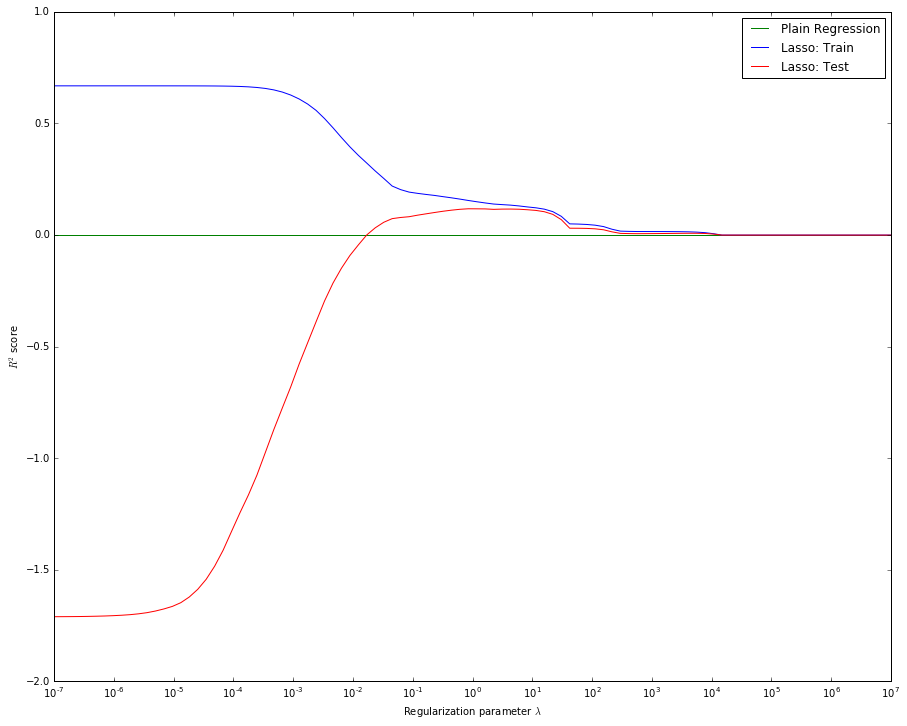

In [9]:
# Run for different values of lambda for Lasso with Max_iter=200
from sklearn.cross_validation import train_test_split

X = pd_fund_cate.drop('TARGET_D', axis=1) 
y = pd_fund_cate['TARGET_D']

_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.50)    

lambda_min = -7
lambda_max = 7

num_lambdas = 100
num_predictors = X.shape[1]

lambdas= np.linspace(lambda_min,lambda_max, num_lambdas)

train_r_squared = np.zeros(num_lambdas)
test_r_squared = np.zeros(num_lambdas)
test_r_squared_plain =0.0
coeff_a =np.zeros((num_lambdas, num_predictors))

for ind, i in enumerate(lambdas):    
    # Fit ridge regression on train set
    reg = Lasso_Reg(alpha =10**i, max_iter=200)
    reg.fit(X_train, y_train)
       
    # Evaluate train & test performance
    coeff_a[ind,:] = reg.coef_
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)

# Plot train an test R-squared as a function parameter value
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

ax.axhline(y = test_r_squared_plain, c='g', label = 'Zero Line')
ax.semilogx(10.0**lambdas, (train_r_squared), c='b', label='Lasso: Train')
ax.semilogx(10.0**lambdas, (test_r_squared), c='r', label='Lasso: Test')


ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'$R^2$ score')

ax.legend(loc = 'best')

print 'Lasso Regression: max R^2 score on training set', max(train_r_squared)
print 'Lasso Regression: max R^2 score on test set', max(test_r_squared)

plt.show()


Q. How good is your model? 

A. While trying best fitting with Linear, Ridge and Lasso regressions we got the best train score with Ridge regression of 0.69 when lambda > 1000, but much worse test score of 0.09.

With Lasso regressions we got the best test score with lambda ~ 1 when R^2 for Test data was ~0.12, it came out a train score of 0.66.

We increased the Max_iterations in the last model, but  the iterations are taking lot longer for Max_iteration > 200 it does not make sense to try for higher precision.

In [86]:
#Q. Evaluate the total profit of the fitted model
num_of_mailing  =  95412 
cost_of_mailing = 7
total_cost = num_of_mailing*cost_of_mailing
mean_net_return = round(num_of_mailing*y.mean())
print 'Net Proceeds = $',(mean_net_return)
print 'Net Cost     = $',(total_cost)
print 'Net Profit   = $',(mean_net_return - total_cost)

Net Proceeds = $ 808017.0
Net Cost     = $ 667884
Net Profit   = $ 140133.0


Q. Use your model to maximize profit. Implement, explain and rigorously justify your strategy. How does your strategry compare with blanket mailing everyone.

Approach: We see clearly that with Lasso our most resonable score can be had when lambda approach from 0.1 to 1.0. Now we are going to examine Coefficients this will help us isolate the predictors which are most important for the modelling.

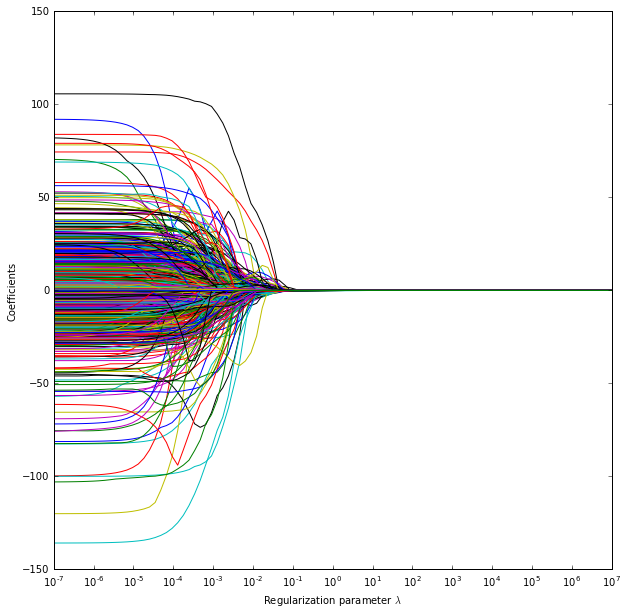

In [72]:
#Now look at the coefficient and how they converging to Lambda values
plt.figure(figsize=(10,10))
h=plt.semilogx(10**lambdas, coeff_a);
plt.ylabel("Coefficients")
plt.xlabel(r'Regularization parameter $\lambda$')
#plt.legend(h, X.columns.values)
plt.show()

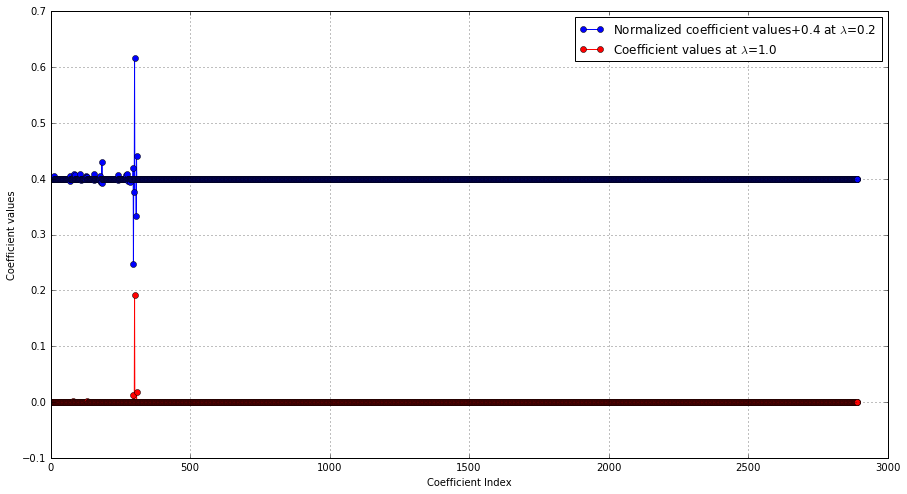

As lamda increased from  0.2 -> 1.0, features reduced set from 21 to 7
Now we can figure out most relevant features
Most relavent feature list:
POP903
HV2
IC2
IC4
RAMNTALL
LASTGIFT
RFA_FREQ


In [106]:

#find all predictors whose coefficient is above the when when lambda ~ 0.2 to 1.0

def get_valid_coeffs(list, value):
    indexs = []
    for index, elem in enumerate(list):
        if elem > value:
            indexs.append(index)
    return indexs

lambda_07 = lambdas[51]
lambda_1 = lambdas[57]
#print coeff_a.shape
high_mean = coeff_a[51].mean()
low_mean = coeff_a[57].mean()

#print high_mean, low_mean

plt.figure(figsize=(15,8))
plt.plot(range(coeff_a.shape[1]),coeff_a[51]+0.4, 'bo-', label=r'Normalized coefficient values+0.4 at $\lambda$=0.2')
#plt.plot(l_values,rsts, 'ro-', label=r'Test Score')
plt.plot(range(coeff_a.shape[1]),coeff_a[57], 'ro-', label=r'Coefficient values at $\lambda$=1.0')

plt.xlabel(r'Coefficient Index'); plt.ylabel(r'Coefficient values')
plt.legend(loc='best')
plt.grid()
plt.show()

feature_list = pd_fund_cate.columns

reduced_set_low_mean = get_valid_coeffs(coeff_a[51], low_mean)
reduced_set_high_mean = get_valid_coeffs(coeff_a[57], high_mean)

print 'As lamda increased from  0.2 -> 1.0, features reduced set from', len(reduced_set_low_mean), 'to', len(reduced_set_high_mean)

print 'Now we can figure out most relevant features'
print 'Most relavent feature list:'
#Now print most relevant coefficient features 
for index, elem in enumerate(feature_list):
    if index in reduced_set_high_mean:
        print feature_list[index] #, coeff_a[57][index]
        


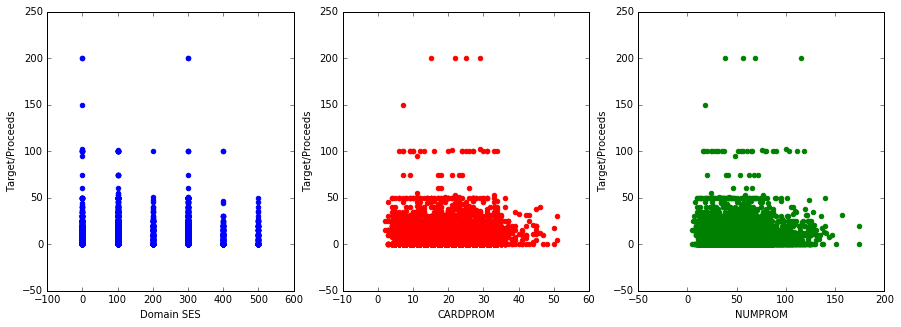

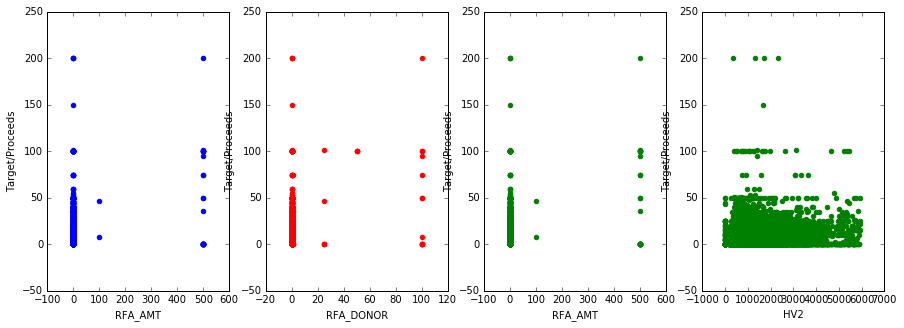

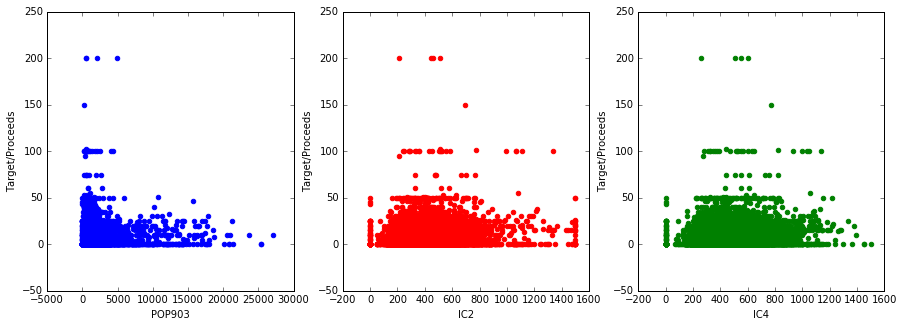

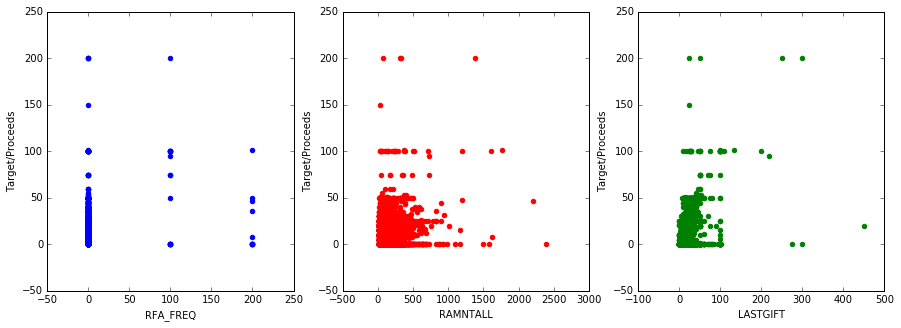

In [85]:
#The relevant coefficients scatter plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(pd_fund_cate['DOMAIN_SES'].values,pd_fund_cate['TARGET_D'].values,color='blue')
ax2.scatter(pd_fund_cate['CARDPROM'].values,pd_fund_cate['TARGET_D'].values,color='red')
ax3.scatter(pd_fund_cate['NUMPROM'].values,pd_fund_cate['TARGET_D'].values,color='green')
ax1.set_xlabel('Domain SES'); ax1.set_ylabel('Target/Proceeds')
ax2.set_xlabel('CARDPROM'); ax2.set_ylabel('Target/Proceeds')
ax3.set_xlabel('NUMPROM'); ax3.set_ylabel('Target/Proceeds')
plt.legend(loc='best')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))
ax1.scatter(pd_fund_cate['RFA_AMT'].values,pd_fund_cate['TARGET_D'].values,color='blue')
ax2.scatter(pd_fund_cate['RFA_DONOR'].values,pd_fund_cate['TARGET_D'].values,color='red')
ax3.scatter(pd_fund_cate['RFA_AMT'].values,pd_fund_cate['TARGET_D'].values,color='green')
ax4.scatter(pd_fund_cate['HV2'].values,pd_fund_cate['TARGET_D'].values,color='green')
ax1.set_xlabel('RFA_AMT'); ax1.set_ylabel('Target/Proceeds')
ax2.set_xlabel('RFA_DONOR'); ax2.set_ylabel('Target/Proceeds')
ax3.set_xlabel('RFA_AMT'); ax3.set_ylabel('Target/Proceeds')
ax4.set_xlabel('HV2'); ax4.set_ylabel('Target/Proceeds')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(pd_fund_cate['POP903'].values,pd_fund_cate['TARGET_D'].values,color='blue')
ax2.scatter(pd_fund_cate['IC2'].values,pd_fund_cate['TARGET_D'].values,color='red')
ax3.scatter(pd_fund_cate['IC4'].values,pd_fund_cate['TARGET_D'].values,color='green')
ax1.set_xlabel('POP903'); ax1.set_ylabel('Target/Proceeds')
ax2.set_xlabel('IC2'); ax2.set_ylabel('Target/Proceeds')
ax3.set_xlabel('IC4'); ax3.set_ylabel('Target/Proceeds')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(pd_fund_cate['RFA_FREQ'].values,pd_fund_cate['TARGET_D'].values,color='blue')
ax2.scatter(pd_fund_cate['RAMNTALL'].values,pd_fund_cate['TARGET_D'].values,color='red')
ax3.scatter(pd_fund_cate['LASTGIFT'].values,pd_fund_cate['TARGET_D'].values,color='green')
ax1.set_xlabel('RFA_FREQ'); ax1.set_ylabel('Target/Proceeds')
ax2.set_xlabel('RAMNTALL'); ax2.set_ylabel('Target/Proceeds')
ax3.set_xlabel('LASTGIFT'); ax3.set_ylabel('Target/Proceeds')


plt.show()

To maximize the profit we have to maximize the predictor output from the given features. As per the model we need to have campaign focused only on certain features in the model.

Looking at the analysis done it reveals us that the target campaign can be maximized for profit if the target audience involving gifts or promotional offers to specific set of population using their regency/frequency/monetary and Frequency of Giving. 

This is proven by the importance these coefficients especially on Frequency of Giving then followed by Dollar amount of most recent gift and lastly Dollar amount of lifetime gifts to date.

Mass mailing everyone would result in loss as mail cost would reduce the profit increased with overhead of dealing and managing would end up costing lot more than any realized monetary gain. Mass mailing would result in loss. 

Q. In hindsight, thoroughly discuss the appropriatenes of using a regression model for this dataset (you must at least address the suitability with respect to profit maximization and model assumptions). Rigorously justify your reasoning. 

This data is not very well organized to do a proper regression modelling to build a profit regression model. First in the hindsight it should have properly segregated for the donor returning with contribution with targeted marketing material to identify them before putting everyone in the similar category. Second there should have been considerable efforts to store data in such a way that it should be made available without adding many categories of the data that has no relations with profitability of the non-profit organization. 

Given that we deal with the problem at hand I think using model is most useful as it has been able to pin point what donor groups should be targeted for campaign and who have higher chance returning donations with meaningful contribution to the non-profit organization. 

Doing this kind of regression would maximize the profit for the non-profit organization.